## Use Trained Model for Inference

This notebook uses a trained version of the GRACE Model to identify aspect terms and their emotions from texts. <br>
In this case, a large dataset from California was used.

To use this notebook, ensure that you have the following:

<b>1.</b> A conda environment that has all the necessary packages. Use the environment.yml file in this repo to create the environment. 
<br>
<b>2.</b> A dataset (in CSV or TSV format), stored in the ```Data/Case Study Data/``` folder
<br>
<b>3.</b> Download and add the bert-base-uncased.tar.gz file from [here](https://drive.google.com/file/d/1G69gztuu5mMAFz90VQIwgKAR0e2MYzyt/view?usp=share_link) and store it in the ```GRACE/bert-base-uncased``` folder.
<br>
<b>4.</b> A trained model file (e.g. ```pytorch_model.bin.9```). Download it from [here](https://drive.google.com/file/d/1gYa1CIW3_jVCO06hOLjhvIVXFQYhgK8F/view?usp=sharing) and add it to the ```GRACE/out_abea_ateacs'``` folder. If using a different one, you need to adjust the file path in the "setup" section.
<br>
<b>5.</b> Make sure the ```abea_train.txt```, ```abea_trial.txt``` and ```abea_test.gold.txt``` files are located in the ```GRACE/data/``` folder (they should already be there). Note: these are just used to read the labels.
<br>
<b>6.</b> You should be able to use this notebook by just checking that the settings in the "setup" section are correct! Everything else can be left as is.


<br>

<b>A bit more information on the model itself </b>

<img align="right" src='https://github.com/ArrowLuo/GRACE/raw/master/accessory/Framework.png' width="40%">


This method for aspect-based sentiment analysis was designed by Luo et al. (2020) and described in the paper [GRACE: Gradient Harmonized and Cascaded Labeling for Aspect-based Sentiment Analysis. Huaishao Luo, Lei Ji, Tianrui Li, Nan Duan, Daxin Jiang. Findings of EMNLP, 2020](https://arxiv.org/abs/2009.10557). The model performs cascaded labeling and incorporates virtual adversarial training and gradient harmonization in its training. It's adapted from the 12-layer, transformer-encoder BERT-base model by Devlin et al. (2019). The method falls into the "End 2 End" category of aspect-based sentiment analysis tasks, meaning it solves two ABSA sub-tasks, ATE (asect term extraction) and ASC (aspect semtiment classification). For the cascaded labeling, wherein first the ATE is performed, followed by the ASC, both tasks share a certain number of lower-level BERT encoder layers. In Luo's original publication it's 9 shared layers. The final 3 layers are trained independently for the ATE and ASC "branches", so as to learn the task-specific patterns. 

The GRACE model co-extracts both the aspect term and the aspect sentiment (here: aspect emotion!)/
Labels: 
- for aspect terms: {B-AP, I-AP, O} 
- for aspect based emotions: {none, happiness, anger, sadness, fear} 

<br>

For more information on the training, see the other notebooks (esp. Notebook 4). 
 


### Setup

In [2]:
# ------------- General Data Handling ---------------------------------
import sys
sys.path.insert(0, 'GRACE/')                                        # Add 'GRACE/' directory at the start of the sys.path for module searching
import os                                                           # used to interact with the operating system
import argparse                                                     # for parsing command line arguments
import random                                                       # to generate random numbers
import numpy as np                                                  # for numerical and array operations
import pandas as pd                                                 # for data manipulation and analysis
from datetime import datetime
import time                                                         # used for adding a break in between the processing of data chunks
import math                                                         # used to ensure a numeric operation is kept in integer rather than float

# ------------- Geographic/ Mapping Libraries --------------------------
import geopandas as gpd
from shapely import wkb, wkt
from shapely.geometry import Point


# ------------- Plotting Data ------------------------------------------
import matplotlib.pyplot as plt                                      # A plotting library for creating static, interactive, and animated visualizations in Python
import matplotlib.ticker as ticker                                   # Provides classes for configuring tick locating and formatting
from matplotlib.ticker import MaxNLocator, FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator
import seaborn as sns; sns.set(style="ticks", color_codes=True)      # Statistical data visualization
import contextily                                                    # Context geo-tiles in Python                                    


# ------------- PyTorch and GRACE-Specific Packages --------------------
import torch                                                         # a deep learning framework for tensor computations and automatic differentiation
import torch.nn.functional as F                                      # torch.nn.functional is for activation and loss functions in pytorch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset # pytorch classes for data handling, sampling, batching etc.
from tokenization import BertTokenizer                               # for tokenizing text into tokens understandable by BERT

from ate_asc_modeling_local_bert_file import BertForSequenceLabeling # Import local files from the GRACE folder in this repo
import ate_asc_modeling_local_bert_file                              # local file containing BERT modeling utilities for ATE and ASC
from file_utils import PYTORCH_PRETRAINED_BERT_CACHE                 # PYTORCH_PRETRAINED_BERT_CACHE to manage caching for pre-trained BERT models
from ate_asc_features import ATEASCProcessor, convert_examples_to_features, get_labels
from tqdm import tqdm                                                # for progress monitoring

In [2]:
# Your device settings (e.g. your laptop, PC, or cloud-based infrastructure)
device = "cuda"                                                 # else "cpu"
n_gpu = 1                                                       # nr. of GPUs being used

# The model file
model_path = 'GRACE/out_abea_ateacs/pytorch_model.bin.9'        # This can be left as is (unless you want to use a different model state)
# model_path = 'GRACE/data/out_refined_nouns_ateacs/pytorch_model.bin.2'   # only nouns in dataset - highest f1 in the asc
# model_path = 'GRACE/data/abea_10_fold_only_nounsout_refined_nouns_9_ateacs/pytorch_model.bin.8'  # after 10-fold cross validation, this model was the best combo of ASC and ATE for noun filtered ABEA (documented in thesis draft)
# model_path = 'GRACE/data/out_refined_evened_out_less_happy_ateacs/pytorch_model.bin.11'
# model_path = 'GRACE/data/out_no_ghl_ateasc/pytorch_model.bin.14'
# model_path = 'GRACE/data/out_LR_adaption1_9shared_ateacs/pytorch_model.bin.10'

# The Data you want to analyse
data_path = "Data/Case Study Data/tweets_california_2020.tsv"   # Adjust this to your own data path! 
is_csv = False                                                  # If False, assumes this is a TSV file! 
use_subset = False                                              # Do you want to use a smaller random sample of your dataset? (e.g. for testing)
sample_size = 1000                                              # The size of your random sample (must be smaller than overall dataset size)
use_chunks = True                                               # whether or not to split the dataset into smaller chunks
chunk_size = 2000000

### Load Model with Correct Labels and Training State

In [3]:
# set arguments required for model initialization
args = argparse.Namespace(
    data_dir='GRACE/data/', 
    bert_model='bert-base-uncased',
    init_model=None,
    task_name="ate_asc",
    data_name="abea",
    train_file='abea_train.txt',
    valid_file='abea_trial.txt',
    test_file='abea_test.gold.txt',
    output_dir='out_testing/',
    seed = 42,
    do_lower_case=True,
    local_rank=-1,
    eval_batch_size=32,
    max_seq_length=128,
    use_ghl=True, 
    use_vat=False, 
    use_decoder=True, 
    num_decoder_layer=2, 
    decoder_shared_layer=3)

random.seed(args.seed)
os.environ['PYTHONHASHSEED'] = str(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

n_gpu = 1
data_name = args.data_name.lower()
task_name = args.task_name.lower()
task_config = {
    "use_ghl": True,
    "use_vat": False,
    "num_decoder_layer": 2,
    "decoder_shared_layer": 3,
}

In [4]:
# dataloader to preprocess the input data
def dataloader_val(args, tokenizer, file_path, label_tp_list, set_type="val"):

    dataset = ATEASCProcessor(file_path=file_path, set_type=set_type)
    print("Loaded val file: {}".format(file_path))

    eval_features = convert_examples_to_features(dataset.examples, label_tp_list,
                                                 args.max_seq_length, tokenizer, verbose_logging=False)

    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_at_label_ids = torch.tensor([f.at_label_id for f in eval_features], dtype=torch.long)
    all_as_label_ids = torch.tensor([f.as_label_id for f in eval_features], dtype=torch.long)

    all_label_mask = torch.tensor([f.label_mask for f in eval_features], dtype=torch.long)
    all_label_mask_X = torch.tensor([f.label_mask_X for f in eval_features], dtype=torch.long)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_at_label_ids, all_as_label_ids,
                              all_label_mask, all_label_mask_X)

    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

    return eval_dataloader, eval_data

# function to initialise the model using the model file (the .bin file), the correct labels, and settings
def load_model(model_file, args, num_tp_labels, task_config, device):
    model_file = model_file
    if os.path.exists(model_file):
        model_state_dict = torch.load(model_file, map_location='cpu')
        print("Model loaded from %s", model_file)
        model = BertForSequenceLabeling.from_pretrained(args.bert_model, cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(args.local_rank),
                                                        state_dict=model_state_dict, num_tp_labels=num_tp_labels,
                                                        task_config=task_config)
        model.to(device)
    else:
        model = None
    return model

In [5]:
# load bert tokenizer (bert-base-uncased)
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

07/30/2024 12:17:17 - INFO - tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\chris\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [6]:
file_path = os.path.join(args.data_dir, args.train_file)
print(f"Loading task specific labels from {file_path}")

# the ATEASCProcessor reads data and splits it into corpus and label list for ATE and ASC
dataset = ATEASCProcessor(file_path=file_path, set_type="train")
at_labels, as_labels = get_labels(dataset.label_tp_list)
label_tp_list = (at_labels, as_labels)

at_num_labels = len(label_tp_list[0])
as_num_labels = len(label_tp_list[1])
num_tp_labels = (at_num_labels, as_num_labels)

task_config["at_labels"] = label_tp_list[0]

at_label_list, as_label_list = label_tp_list
at_label_map = {i: label for i, label in enumerate(at_label_list)}
as_label_map = {i: label for i, label in enumerate(as_label_list)}

# print infos to double-check all is correct
print(f"ATE labels: {at_label_map}")
print(f"ASC labels: {as_label_map}")

Loading task specific labels from GRACE/data/abea_train.txt
ATE labels: {0: 'O', 1: 'B-AP', 2: 'I-AP'}
ASC labels: {0: 'O', 1: 'ANGER', 2: 'SADNESS', 3: 'HAPPINESS', 4: 'FEAR'}


In [7]:
# an adapted ate_asc_modeling_local_bert_file.py is imported here, which loads the model from a folder in the repo ('GRACE/bert-base-uncased/bert-base-uncased.tar.gz')

model_file = model_path
model = load_model(model_file, args, num_tp_labels, task_config, device)

if hasattr(model, 'module'):
    print('has module')
    model = model.module

# set model to eval mode (turn off training features e.g. dropout)
model.eval()

Model loaded from %s GRACE/out_abea_ateacs/pytorch_model.bin.9
loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at C:\Users\chris\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
extracting archive file C:\Users\chris\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir C:\Users\chris\AppData\Local\Temp\tmpsa2x8brd


07/30/2024 12:17:22 - INFO - decoder_module -   loading archive file c:\Users\chris\Documents\PLUS SharePoint\Universität Salzburg\AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer\1 - Code\ABEA Repo\GRACE\decoder-bert-base


BertForSequenceLabeling(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
  

### Load Dataset

In [8]:
# Example: California Wildfire Dataset from 2020
if is_csv:
    print("Reading data from CSV.")
    df = pd.read_csv(data_path)

# if it's a TSV
else:
    print("Reading data from TSV.")
    df = pd.read_csv(data_path, delimiter='\t')

print(f"Loaded dataset: {len(df)} rows.")

Reading data from TSV.
Loaded dataset: 34678576 rows.


In [9]:
# get a first impression of the data
df.head()

,message_id,date,text,geom
0,1333561451320061953,2020-12-01 00:00:01,@krystal.jordan_ #fitness #workout #clubdress ...,0101000020E6100000CFF753E3A58F5DC048BF7D1D3807...
1,1333561453605834752,2020-12-01 00:00:01,@willw your matrix thread confused me so much....,0103000020E610000001000000050000009E961FB8CA9A...
2,1333561456525078529,2020-12-01 00:00:02,@edukatdedukater I was disappointed 😞,0103000020E61000000100000005000000E0641BB80390...
3,1333561465211547648,2020-12-01 00:00:04,"Nervous to apply for a job like ""Seasonal Pers...",0101000020E61000004D1BC4BDE87E5DC01AE9FB5F6408...
4,1333561466247540736,2020-12-01 00:00:04,The cool thing about the e dirt bike is since ...,0103000020E6100000010000000500000042D0D1AA96D4...


### Pre-Processing: Filter Data for Relevance

<b>Exclude Polygons that are over 1000m<sup>2</sup></b>
<br><br>
Below I am setting the geodataframe's CRS to a projected CRS local to California. Then I am filtering out all the polygon rows that have an area larger than 1000 square miles. I think this is a good threshold since it is twice the size of California's largest city (LA: 503 square miles). This will help exclude all the polgyons that are too large to have a meaningful geolocation. 

In [10]:
# Function to convert geom to geometry object from WKB
def convert_wkb(geom):
    try:
        return wkb.loads(bytes.fromhex(geom))
    except Exception as e:
        print(f"Error converting geom: {geom}, Error: {e}")
        return None

# Apply the conversion, dropping rows with invalid geometry
df['geometry'] = df['geom'].apply(convert_wkb)
gdf = gpd.GeoDataFrame(df.dropna(subset=['geometry']), geometry='geometry')


In [11]:
# filter for only the tweets that have a point location

# Create a new column called "geom_type" which shows whether the data is a point or polygon
gdf['geom_type'] = gdf['geometry'].apply(lambda x: x.geom_type)
print(gdf.geom_type.value_counts())

gdf.head()

Polygon    32283544
Point       2395032
Name: count, dtype: int64


,message_id,date,text,geom,geometry,geom_type
0,1333561451320061953,2020-12-01 00:00:01,@krystal.jordan_ #fitness #workout #clubdress ...,0101000020E6100000CFF753E3A58F5DC048BF7D1D3807...,POINT (-118.24450 34.05640),Point
1,1333561453605834752,2020-12-01 00:00:01,@willw your matrix thread confused me so much....,0103000020E610000001000000050000009E961FB8CA9A...,"POLYGON ((-118.41862 33.72200, -118.41862 33.7...",Polygon
2,1333561456525078529,2020-12-01 00:00:02,@edukatdedukater I was disappointed 😞,0103000020E61000000100000005000000E0641BB80390...,"POLYGON ((-118.25023 33.73291, -118.25023 33.8...",Polygon
3,1333561465211547648,2020-12-01 00:00:04,"Nervous to apply for a job like ""Seasonal Pers...",0101000020E61000004D1BC4BDE87E5DC01AE9FB5F6408...,POINT (-117.98296 34.06556),Point
4,1333561466247540736,2020-12-01 00:00:04,The cool thing about the e dirt bike is since ...,0103000020E6100000010000000500000042D0D1AA96D4...,"POLYGON ((-119.32170 34.23444, -119.32170 34.3...",Polygon


In [12]:
print(gdf.crs)

None


In [13]:
# set the CRS
gdf = gdf.set_crs("EPSG:4326", allow_override=True)

# projected CRS 
gdf = gdf.to_crs(epsg=3310)  # NAD83 / California Albers, for accurate area calculation in square meters

# Calculate area in square meters, then convert to square miles (if using miles, otherwise adjust units)
gdf['area_sq_miles'] = gdf['geometry'].area * 3.861e-7

# Set the threshold (for reference, largest city in CA, LA, is 500square miles, 
# average county size in California is roughly 2,000 square miles)
threshold_area = 1000

# Filter out polygons with area greater than the threshold
filtered_gdf = gdf[
    (gdf['geom_type'] == 'Point') |                                                 # include all points
    ((gdf['geom_type'] == 'Polygon') & (gdf['area_sq_miles'] <= threshold_area))    # include polygons under threshold
]


# Display the filtered GeoDataFrame
print(f"After removing all polygon geometries that are larger than 1000 square miles, the dataset contains {len(filtered_gdf)} rows.")


After removing all polygon geometries that are larger than 1000 square miles, the dataset contains 27055235 rows.


<b>Check for empty 'text' values in the Dataset and Exclude these</b> 
<br><br>
An empty string value in the 'text' column will cause issues later on when trying to work with the text (e.g. when using the ```split``` method). Therefore I just exclude any empty rows upfront. 

In [14]:
# removing any rows that have 'NaN' values in the text column
filtered_gdf = filtered_gdf.dropna(subset=['text'])
print(f"After removing all NaN values, the dataset contains {len(filtered_gdf)} rows.")

# filter out any rows where the text is just an empty string (after removing whitespaces)
filtered_gdf = filtered_gdf[filtered_gdf['text'].str.strip() != '']
print(f"After removing all empty string values, the dataset contains {len(filtered_gdf)} rows.")

# convert all the remaining text values to string to ensure uniformity
filtered_gdf['text'] = filtered_gdf['text'].astype(str)


After removing all NaN values, the dataset contains 27055140 rows.
After removing all empty string values, the dataset contains 27055140 rows.


<b>Get a Few Date Stats on the Dataset for Reporting</b>
<br><br>
In the next step, I am calculating the beginning and end dates found in the dataset. Then a histogram is created to show the date distribution visually. 

In [15]:
# convert 'date' column to datetime
filtered_gdf['date'] = pd.to_datetime(df['date'])

# get info on the time frame
start_date = filtered_gdf['date'].min()
end_date = filtered_gdf['date'].max()

print(f"Start date: {start_date}, end date: {end_date}.")

Start date: 2020-04-01 00:00:01, end date: 2020-12-31 23:59:55.


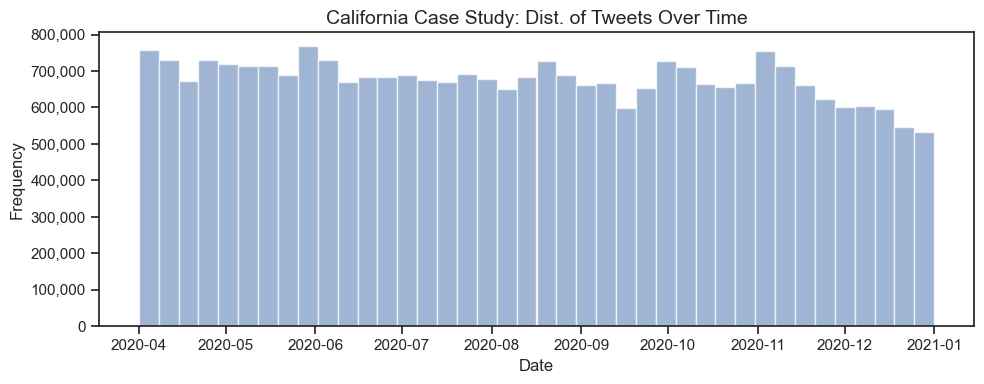

In [16]:
# Calculate the number of weeks in the date range
num_weeks = (end_date - start_date).days // 7 + 1

# Plotting the histogram
fig, ax = plt.subplots(figsize=(10, 4))

# Histogram of the time for each row with specific style
filtered_gdf['date'].hist(ax=ax, bins=num_weeks, color='#7895C2', edgecolor='white', alpha=0.7)

# Customizing the plot to match the style
ax.xaxis.set_major_locator(MonthLocator())  # Set locator to month
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # Format labels to show year-month
# format y axis to show full numbers
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.grid(False)  # Remove grid lines
ax.set_facecolor('white')  # Set the background color to white
ax.set_title('California Case Study: Dist. of Tweets Over Time', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

<b>Show the Location of the Points and Centroids of Polygons on a Map for Reporting</b>
<br><br>
Here, the centroids of the polygons are calculated and then used in a seaborn jointplot that shows the points on a map along with the distribution density.

In [17]:
# create a copy of the filtered_gdf just for the sake of creating a points only map visualisation
points_only_filtered_gdf = filtered_gdf.copy()

# Iterate over each row in the geodataframe using a for-loop
for index, row in points_only_filtered_gdf.iterrows():

    # If-condition to check if the row['geom_type'] is a Polygon
    if row['geom_type'] == 'Polygon':

        # Get the centroid of the polygon
        centroid = row['geometry'].centroid

        # Create a new Point geometry from the centroid
        points_only_filtered_gdf.at[index, 'geometry'] = centroid

        # Update the geom_type of the row to 'Point'
        row['geom_type'] = 'Point'

# Check the geometry types again to make sure we successfully converted all polygons to points
print(points_only_filtered_gdf.geom_type.value_counts())

Point    27055140
Name: count, dtype: int64


In [18]:
print(points_only_filtered_gdf.geom_type.value_counts())

Point    27055140
Name: count, dtype: int64


In [19]:
points_only_filtered_gdf.sample(5)

,message_id,date,text,geom,geometry,geom_type,area_sq_miles
30996318,1318797632756613120,2020-10-21 06:13:52,"@aaronjville It’s not the back of my neck, it’...",0103000020E61000000100000005000000E0641BB80390...,POINT (170692.666 -465670.464),Polygon,113.124745
251877,1256076211526103041,2020-05-01 04:21:20,Lmfao,0103000020E61000000100000005000000DEE522BE137F...,POINT (188995.241 -440437.162),Polygon,12.298272
29141420,1312887512545730560,2020-10-04 22:49:09,"Join the TJX Companies, Inc. team! See our lat...",0101000020E6100000E03AB5E9BEA85EC068041BD7BF1D...,POINT (-230480.835 27222.403),Point,0.000000
31032532,1271446061803016197,2020-06-12 14:15:38,You have drawn more than the blood of trees. #...,0101000020E6100000CFF753E3A58F5DC048BF7D1D3807...,POINT (162056.364 -438410.080),Point,0.000000
33329895,1274407702379130881,2020-06-20 18:24:08,"@Honda NSX, Still fighting and hoping to have ...",0103000020E61000000100000005000000EF737CB43899...,POINT (152635.606 -463282.970),Polygon,36.212756


In [20]:
# create columns for latitude and longitude
points_only_filtered_gdf['lat'] = points_only_filtered_gdf['geometry'].apply(lambda x : x.y if x else np.nan)
points_only_filtered_gdf['lon'] = points_only_filtered_gdf['geometry'].apply(lambda x : x.x if x else np.nan)

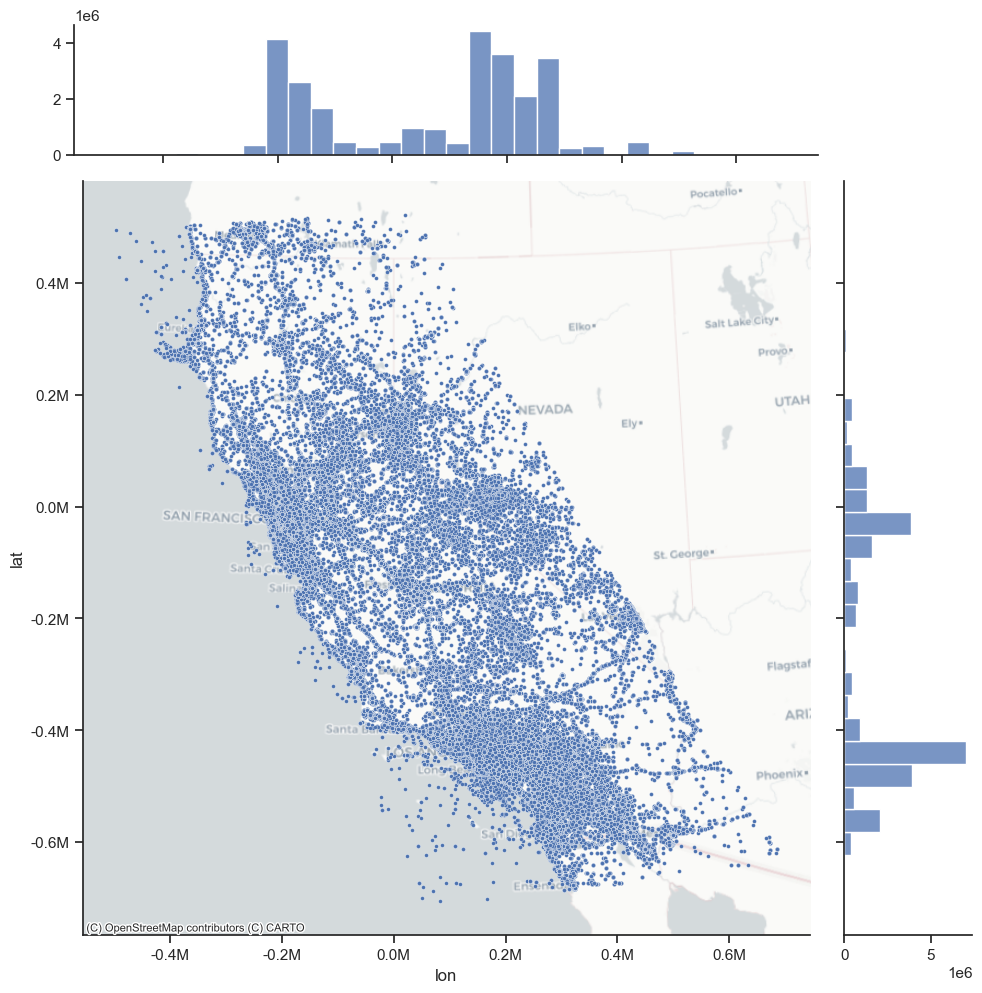

In [21]:
# Function to format numbers in millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


# Generate a jointplot with a base map to show spatial distribution
joint_axes = sns.jointplot(
    x=points_only_filtered_gdf["lon"], # specify the longitude column of the dataset
    y=points_only_filtered_gdf["lat"], # specify the latitude column of the dataset
    data=df, # specify the dataset to be plotted
    s=8,
    height=10, # Increased height for a larger plot
    ratio=5,  # ratio controls size of the bar charts on top and right
    marginal_ticks=True, # specify the size of the point markers (in numeric terms, e.g. 3)
    marginal_kws=dict(bins=30) # Increase the number of bins
)

formatter = FuncFormatter(millions)
joint_axes.ax_marg_x.xaxis.set_major_formatter(formatter)
joint_axes.ax_marg_y.yaxis.set_major_formatter(formatter)

contextily.add_basemap(
    joint_axes.ax_joint, # join the basemap with the plot
    crs='EPSG:3310', # specify the coordinate reference system (should be the same as your data)
    source=contextily.providers.CartoDB.Positron # the style of the base map (but you can change it if you like)
)


<b>Return the 'filtered_gdf' to the generic name 'df'</b>
<br><br>
I set up all the following functions to work with the generic 'df', so rather than changing all the variables, the filtered_gdf will now be re-converted to 'df'.

In [22]:
# return the dataset to the 'df' name for the following functions
df = filtered_gdf.copy()

<b>Sampling and Turn into Chunks</b>
<br><br>
If set to ```True``` in the 'Setup' at the beginning of this notebook - the df will now be sampled and turned into chunks for the GRACE Model use. 

In [23]:
if use_subset:
    df = df.sample(sample_size)
    print(f"Sample created: {len(df)} rows.")

In [24]:
def dataframe_chunk_iter(df, chunk_size):
    """
    Splits a df into chunks of a certain size.
    
    Args:
        df (pd.DataFrame): The DataFrame to split.
        chunk_size (int): The size of each chunk.
    
    Yields:
        pd.DataFrame: A chunk of the original DataFrame.
    """
    for start in range(0, len(df), chunk_size):
        yield df[start:start + chunk_size]

In [25]:
if use_chunks:
    
    print("Creating chunks...")

    # check for chunk size and whether the chunks are larger than the actual dataset (which can happen when a subset is used, e.g. for testing)
    if chunk_size > len(df):

        # make sure to keep the data type as an integer...! 
        chunk_size = math.ceil(len(df) / 4)  # Round up to ensure the chunk size covers the dataset
        print(f"Since the df was sampled down to {len(df)}, the chunks needed to be reduced. The chunks are now of size {chunk_size}.")
    
    # create the actual iterator
    chunk_iter = dataframe_chunk_iter(df, chunk_size)


Creating chunks...


### Pre-processing: Re-format for GRACE Model (for Inference in One Go)

In [26]:
if not use_chunks:
    # Preprocess the data to fit the GRACE Model format
    
    # text column to list
    text_list = list(df['text'].astype(str))

    # input format for GRACE model
    addition = ' - - O O O'
    convert_to_doc = []

    # iteratively apply re-formatting and save to new list
    for tweet in text_list:
        words = tweet.split()
        words_with_addition = []
        for word in words:
            new_word = word + addition
            #print(new_word)
            words_with_addition.append(new_word)
        convert_to_doc.append(words_with_addition)

    # Save in the Case study folder
    path_to_reformatted_data = "Data/Case Study Data/reformatted.txt"
    with open(path_to_reformatted_data, mode = "w", encoding='utf-8') as f:
        for tweet in convert_to_doc:
            for word in tweet:
                f.write("%s\n" % word)
            f.write("\n")

In [27]:
if not use_chunks:

    DATALOADER_DICT = {}
    # only "eval" state is needed ("train" is left out)
    DATALOADER_DICT["ate_asc"] = {"eval":dataloader_val}
    # Create dataloader with the prepared dataset
    eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, path_to_reformatted_data, label_tp_list=label_tp_list, set_type="val")

### Run Model on Data in One Go

In [28]:
if not use_chunks:

    # empty lists for both the identified aspect terms and the related emotions
    pred_aspect_terms = []
    pred_aspect_emotions = []

    # for-loop to iterate over the preprocessed outputs from the "eval_dataloader" 
    for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
    # for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in tqdm(eval_dataloader, desc="Evaluating"):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        at_label_ids = at_label_ids.to(device)
        as_label_ids = as_label_ids.to(device)
        label_mask = label_mask.to(device)
        label_mask_X = label_mask_X.to(device)
        
        with torch.no_grad():
            # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
            logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
            pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
            decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
            logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
            decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
            logits = logits.detach().cpu().numpy()
            decoder_logits = decoder_logits.detach().cpu().numpy()
            
        at_label_ids = at_label_ids.to('cpu').numpy()
        as_label_ids = as_label_ids.to('cpu').numpy()
        label_mask = label_mask.to('cpu').numpy()
        
        for i, mask_i in enumerate(label_mask):
            temp_1 = []
            temp_2 = []
            for j, l in enumerate(mask_i):
                if l > -1:
                    temp_1.append(at_label_map[logits[i][j]])
                    temp_2.append(as_label_map[decoder_logits[i][j]])
                    
            pred_aspect_terms.append(temp_1)
            pred_aspect_emotions.append(temp_2)

    # add new aspect term labels and aspect sentiment labels as columns to twemlab dataframe
    df['aspect_term_preds'] = pred_aspect_terms
    df['aspect_emo_preds'] = pred_aspect_emotions

    # ------------------------------------------------------------------------------
    # Next step, extract the aspect term and sentiment and store in twemlab dataframe
    aspect_terms = []
    aspect_sentiments = []

    # for every row (tweet)
    for idx, row in df.iterrows():
        
        row_aspect_terms = []
        row_aspect_sentiments = []

        # split text into individual words
        words = row['text'].split()

        # Loop through aspect_term_preds
        for i, pred in enumerate(row['aspect_term_preds']):
            if pred == 'B-AP':
                # Initialize term with the current word
                term = words[i] if i < len(words) else ''
                sent = row['aspect_emo_preds'][i]

                # check for continuation of aspect term ('I-AP')
                j = i + 1
                while j < len(row['aspect_term_preds']) and row['aspect_term_preds'][j] == 'I-AP':
                    # Append word to term if within bounds
                    if j < len(words):
                        term += ' ' + words[j]
                        sent += ' ' + row['aspect_emo_preds'][j]
                    j += 1

                # save the aspect term and emotion
                if term:  # Only add non-empty terms
                    row_aspect_terms.append(term)
                    row_aspect_sentiments.append(sent)

        # append extracted terms and sentiments to respective lists
        aspect_terms.append(row_aspect_terms)
        aspect_sentiments.append(row_aspect_sentiments)

    # assign the lists back to the DataFrame
    df['aspect_terms'] = aspect_terms
    df['aspect_emotions'] = aspect_sentiments

    # remove the previous columns
    df.drop(columns=['aspect_term_preds', 'aspect_emo_preds'], inplace=True)

### Run Model on the Prepared Data in Chunks

In [29]:
# Function to process each chunk
def process_chunk(chunk, chunk_index):

    print(f"Working on chunk {chunk_index}")

    # Preprocess the data to fit the GRACE Model format
    text_list = list(chunk['text'].astype(str))

    addition = ' - - O O O'
    convert_to_doc = []

    for tweet in text_list:
        words = tweet.split()
        words_with_addition = [word + addition for word in words]
        convert_to_doc.append(words_with_addition)

    path_to_reformatted_data = f"Data/Case Study Data/chunks/reformatted_chunk_{chunk_index}.txt"
    with open(path_to_reformatted_data, mode="w", encoding='utf-8') as f:
        for tweet in convert_to_doc:
            for word in tweet:
                f.write("%s\n" % word)
            f.write("\n")

    DATALOADER_DICT = {}
    DATALOADER_DICT["ate_asc"] = {"eval": dataloader_val}
    eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, path_to_reformatted_data, label_tp_list=label_tp_list, set_type="val")

    pred_aspect_terms = []
    pred_aspect_emotions = []

    # for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
    for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in tqdm(eval_dataloader, desc="Evaluating"):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        at_label_ids = at_label_ids.to(device)
        as_label_ids = as_label_ids.to(device)
        label_mask = label_mask.to(device)
        label_mask_X = label_mask_X.to(device)

        with torch.no_grad():
            logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
            pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
            decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
            logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
            decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
            logits = logits.detach().cpu().numpy()
            decoder_logits = decoder_logits.detach().cpu().numpy()

        at_label_ids = at_label_ids.to('cpu').numpy()
        as_label_ids = as_label_ids.to('cpu').numpy()
        label_mask = label_mask.to('cpu').numpy()

        for i, mask_i in enumerate(label_mask):
            temp_1 = []
            temp_2 = []
            for j, l in enumerate(mask_i):
                if l > -1:
                    temp_1.append(at_label_map[logits[i][j]])
                    temp_2.append(as_label_map[decoder_logits[i][j]])

            pred_aspect_terms.append(temp_1)
            pred_aspect_emotions.append(temp_2)

    chunk['aspect_term_preds'] = pred_aspect_terms
    chunk['aspect_emo_preds'] = pred_aspect_emotions

    aspect_terms = []
    aspect_sentiments = []

    for idx, row in chunk.iterrows():
        row_aspect_terms = []
        row_aspect_sentiments = []
        words = row['text'].split()

        for i, pred in enumerate(row['aspect_term_preds']):
            if pred == 'B-AP':
                term = words[i] if i < len(words) else ''
                sent = row['aspect_emo_preds'][i]
                j = i + 1
                while j < len(row['aspect_term_preds']) and row['aspect_term_preds'][j] == 'I-AP':
                    if j < len(words):
                        term += ' ' + words[j]
                        sent += ' ' + row['aspect_emo_preds'][j]
                    j += 1

                if term:
                    row_aspect_terms.append(term)
                    row_aspect_sentiments.append(sent)

        aspect_terms.append(row_aspect_terms)
        aspect_sentiments.append(row_aspect_sentiments)

    chunk['aspect_terms'] = aspect_terms
    chunk['aspect_emotions'] = aspect_sentiments
    chunk.drop(columns=['aspect_term_preds', 'aspect_emo_preds'], inplace=True)

    chunk.to_csv(f"Data/Case Study Data/chunks/abea_results_chunk_{chunk_index}.csv", index=False)


    # ------------- SHOW RESULT STATS -------------------
    chunk['aspect_emotions'] = chunk['aspect_emotions'].astype(str)
    # Counting occurrences of each emotion
    hap_even = chunk['aspect_emotions'].str.contains('HAPPINESS', case=False, na=False).sum()
    sad_even = chunk['aspect_emotions'].str.contains('SADNESS', case=False, na=False).sum()
    fea_even = chunk['aspect_emotions'].str.contains('FEAR', case=False, na=False).sum()
    ang_even = chunk['aspect_emotions'].str.contains('ANGER', case=False, na=False).sum()
    non_even = (~chunk['aspect_emotions'].str.contains('HAPPINESS|SADNESS|FEAR|ANGER', case=False, na=False)).sum()

    # Printing the results
    print(f"Happiness: {hap_even}")
    print(f"Sadness: {sad_even}")
    print(f"Fear: {fea_even}")
    print(f"Anger: {ang_even}")
    print(f"None: {non_even}")

    labels = ['Happiness', 'Anger', 'Sadness', 'Fear', 'None']
    values = [hap_even, ang_even, sad_even, fea_even, non_even]
    colors = ['#68bc00', '#d33115', '#73d8ff', '#7b64ff', '#c4c4c4']

    #  figure size, face color and edge color
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.set_facecolor('white')
    ax.set_facecolor('white')

    # bar chart
    bars = ax.bar(labels, values, color=colors, edgecolor='darkgrey')

    # value labels above bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

    # rotate x-axis labels if they overlap
    plt.xticks(rotation=45)

    # font sizes
    ax.set_title('Inference Stats', fontsize=16)
    ax.set_xlabel('Emotion Labels', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

    # gridlines with light grey color
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)

    # Set axis limits
    ax.set_ylim(0, max(values) * 1.15)  # Adding some space above the tallest bar

    # set y-axis to show integers only
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Tight layout to fit everything
    plt.tight_layout()

    plt.show()



In [ ]:
if use_chunks:
    for chunk_index, chunk in enumerate(chunk_iter):

        process_chunk(chunk, chunk_index)

        # added a 'break' in between each chunk
        print(f"Completed chunk {chunk_index}. Pausing for a break....")

        # go to sleep for 15 mins, 900 seconds (300 = 5 mins)
        time.sleep(60)

### View Results

In [31]:
# re-load all the results into a single df 

folder = 'Data/Case Study Data/chunks'
all_files = os.listdir(folder)

# use a list comprehension to find only the result files (not the reformatted files)
csv_files = [f for f in all_files if f.startswith("abea_results_chunk_") and f.endswith(".csv")]

# make sure they're in the correct order - not that it really matters
csv_files.sort()

dfs = []

for file in csv_files: 
    file_path = os.path.join(folder, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# join all together
combined_df = pd.concat(dfs, ignore_index=True)

print(f"Re-loaded all results into a single DF. Length: {len(combined_df)}")


Re-loaded all results into a single DF. Length: 27055140


In [32]:
combined_df.sample(10)

,message_id,date,text,geom,geometry,geom_type,area_sq_miles,aspect_terms,aspect_emotions
9795471,1322605074024075264,2020-10-31 18:23:17,She said line me up 🤣🤣🤣,0103000020E6100000010000000500000064B0E2546B7C...,POLYGON ((190664.74330896587 -478282.754394822...,Polygon,43.331048,['She'],['ANGER']
18761449,1261724717142032384,2020-05-16 18:26:28,So how many video did I post last night?? Oof,0103000020E61000000100000005000000594C6C3EAEFB...,POLYGON ((6025.607659495498 -152004.0680875866...,Polygon,314.787292,[],[]
517995,1334564021106720769,2020-12-03 18:23:52,If people are saying BLM is boring I suggest t...,0103000020E610000001000000050000000C772E8CF4A0...,POLYGON ((-221388.7279698656 -31335.3041264326...,Polygon,74.616853,"['BLM', '#RHOA']","['HAPPINESS', 'HAPPINESS']"
644404,1334885319196327937,2020-12-04 15:40:35,Gm tweeps!!!,0103000020E61000000100000005000000B35C363AE764...,POLYGON ((-137449.88572796126 48004.5993409105...,Polygon,197.843535,['Gm'],['SADNESS']
10218564,1275104951367163904,2020-06-22 16:34:45,"@brittany_broski Love that for us, (and the pu...",0103000020E6100000010000000500000038143E5B07C7...,POLYGON ((82038.33181246507 -424554.0538003016...,Polygon,40.473719,['that'],['HAPPINESS']
22369855,1251929693676122112,2020-04-19 17:44:33,I’m not even gonna flex. They have some cold a...,0103000020E610000001000000050000006E693524EE95...,POLYGON ((-206251.54705287406 -32701.315582759...,Polygon,159.546636,[],[]
2645093,1245207568558907393,2020-04-01 04:33:13,https://t.co/27Y16JE2Sg,0103000020E61000000100000005000000195932C7F286...,POLYGON ((175068.82879726254 -461505.528517386...,Polygon,13.277740,[],[]
18018663,1297317996323536898,2020-08-22 23:41:27,native.grime PANIC IN D.C. They never thought ...,0101000020E6100000D61113164DC35DC0613A4AB1651C...,POINT (87372.05454253602 -421118.4690524144),Point,0.000000,['they'],['SADNESS']
15471462,1248637732940681219,2020-04-10 15:43:28,Literally had to say this so many times,0103000020E61000000100000005000000198C11894282...,POLYGON ((-180404.04925803974 -89574.488444635...,Polygon,338.705367,['this'],['SADNESS']
2812491,1338688540083773440,2020-12-15 03:33:14,been a minute 👄 https://t.co/E1uoyEEDRv,0103000020E61000000100000005000000A8C821E2E679...,POLYGON ((194112.41777359124 -469176.996365371...,Polygon,47.300646,[],[]


In [33]:
combined_df['aspect_emotions'] = combined_df['aspect_emotions'].astype(str)

In [34]:
# Counting occurrences of each emotion
hap_even = combined_df['aspect_emotions'].str.contains('HAPPINESS', case=False, na=False).sum()
sad_even = combined_df['aspect_emotions'].str.contains('SADNESS', case=False, na=False).sum()
fea_even = combined_df['aspect_emotions'].str.contains('FEAR', case=False, na=False).sum()
ang_even = combined_df['aspect_emotions'].str.contains('ANGER', case=False, na=False).sum()
non_even = (~combined_df['aspect_emotions'].str.contains('HAPPINESS|SADNESS|FEAR|ANGER', case=False, na=False)).sum()

# Printing the results
print(f"Happiness: {hap_even}")
print(f"Sadness: {sad_even}")
print(f"Fear: {fea_even}")
print(f"Anger: {ang_even}")
print(f"None: {non_even}")

Happiness: 6817343
Sadness: 4571971
Fear: 2217348
Anger: 1156385
None: 13767989


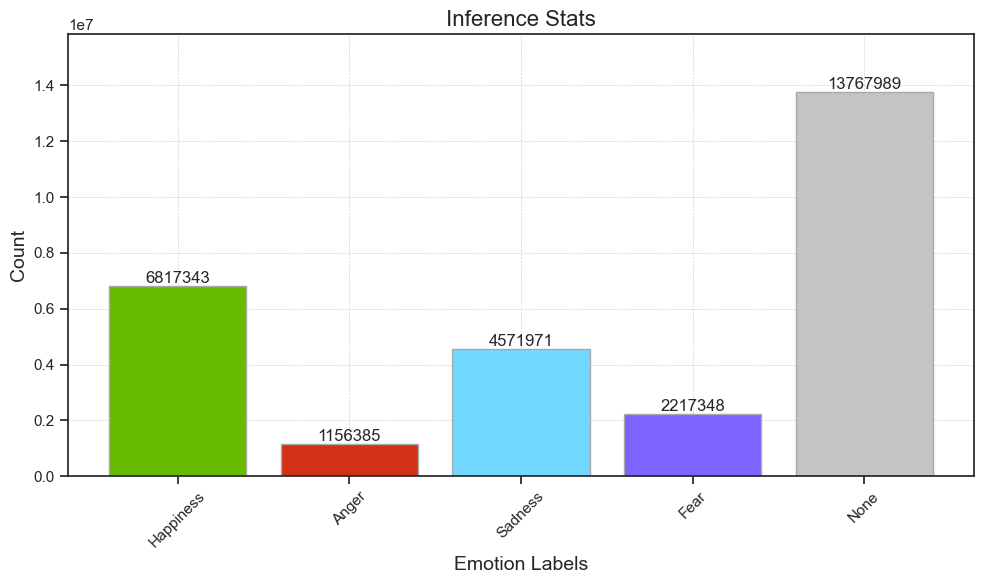

In [35]:
labels = ['Happiness', 'Anger', 'Sadness', 'Fear', 'None']
values = [hap_even, ang_even, sad_even, fea_even, non_even]
colors = ['#68bc00', '#d33115', '#73d8ff', '#7b64ff', '#c4c4c4']

#  figure size, face color and edge color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')
ax.set_facecolor('white')

# bar chart
bars = ax.bar(labels, values, color=colors, edgecolor='darkgrey')

# value labels above bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

# rotate x-axis labels if they overlap
plt.xticks(rotation=45)

# font sizes
ax.set_title('Inference Stats', fontsize=16)
ax.set_xlabel('Emotion Labels', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# gridlines with light grey color
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)

# Set axis limits
ax.set_ylim(0, max(values) * 1.15)  # Adding some space above the tallest bar

# set y-axis to show integers only
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Tight layout to fit everything
plt.tight_layout()

plt.show()


### Save Results

In [36]:
combined_df.to_csv("Data/Case Study Data/abea_results_all.csv")

### Prepare the Data for ArcGIS Pro (create lat and long columns)

First, create a point-only dataset (get centroids from the polygons)

In [3]:
# re load the data
combined_df= pd.read_csv("Data/Case Study Data/abea_results_all.csv")
print(len(combined_df))
combined_df.head()

27055140


,Unnamed: 0,message_id,date,text,geom,geometry,geom_type,area_sq_miles,aspect_terms,aspect_emotions
0,0,1333561451320061953,2020-12-01 00:00:01,@krystal.jordan_ #fitness #workout #clubdress ...,0101000020E6100000CFF753E3A58F5DC048BF7D1D3807...,POINT (162056.36445088877 -438410.07955629425),Point,0.000000,[],[]
1,1,1333561453605834752,2020-12-01 00:00:01,@willw your matrix thread confused me so much....,0103000020E610000001000000050000009E961FB8CA9A...,POLYGON ((146602.7972412611 -475775.4339780831...,Polygon,34.288132,['your matrix thread'],['SADNESS SADNESS SADNESS']
2,2,1333561456525078529,2020-12-01 00:00:02,@edukatdedukater I was disappointed 😞,0103000020E61000000100000005000000E0641BB80390...,POLYGON ((162190.0523187678 -474292.5873673148...,Polygon,113.124745,[],[]
3,3,1333561465211547648,2020-12-01 00:00:04,"Nervous to apply for a job like ""Seasonal Pers...",0101000020E61000004D1BC4BDE87E5DC01AE9FB5F6408...,POINT (186175.50512076315 -436913.78267982835),Point,0.000000,[],[]
4,4,1333561466247540736,2020-12-01 00:00:04,The cool thing about the e dirt bike is since ...,0103000020E6100000010000000500000042D0D1AA96D4...,POLYGON ((62478.55133399873 -419935.4609407363...,Polygon,80.787863,['e dirt bike'],['HAPPINESS HAPPINESS HAPPINESS']


In [4]:
combined_df = combined_df.drop(columns=['geom', 'area_sq_miles'])

# Convert the 'geometry' column from WKT to shapely geometries
combined_df['geometry'] = combined_df['geometry'].apply(wkt.loads)

# Create a GeoDataFrame
combined_gdf = gpd.GeoDataFrame(combined_df, geometry='geometry')

# Set the coordinate reference system (CRS)
combined_gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

# Display the GeoDataFrame
combined_gdf.head()

,Unnamed: 0,message_id,date,text,geometry,geom_type,aspect_terms,aspect_emotions
0,0,1333561451320061953,2020-12-01 00:00:01,@krystal.jordan_ #fitness #workout #clubdress ...,POINT (162056.36445 -438410.07956),Point,[],[]
1,1,1333561453605834752,2020-12-01 00:00:01,@willw your matrix thread confused me so much....,"POLYGON ((146602.79724 -475775.43398, 146466.7...",Polygon,['your matrix thread'],['SADNESS SADNESS SADNESS']
2,2,1333561456525078529,2020-12-01 00:00:02,@edukatdedukater I was disappointed 😞,"POLYGON ((162190.05232 -474292.58737, 161877.7...",Polygon,[],[]
3,3,1333561465211547648,2020-12-01 00:00:04,"Nervous to apply for a job like ""Seasonal Pers...",POINT (186175.50512 -436913.78268),Point,[],[]
4,4,1333561466247540736,2020-12-01 00:00:04,The cool thing about the e dirt bike is since ...,"POLYGON ((62478.55133 -419935.46094, 62390.851...",Polygon,['e dirt bike'],['HAPPINESS HAPPINESS HAPPINESS']


In [5]:
# create a copy of the filtered_gdf just for the sake of creating a points only map visualisation
points_combined_gdf = combined_gdf.copy()
# print(points_combined_gdf.geom_type.value_counts())


In [6]:
# Iterate over each row in the geodataframe using a for-loop
for index, row in points_combined_gdf.iterrows():

    # If-condition to check if the row['geom_type'] is a Polygon
    if row['geom_type'] == 'Polygon':

        # Get the centroid of the polygon
        centroid = row['geometry'].centroid

        # Create a new Point geometry from the centroid
        points_combined_gdf.at[index, 'geometry'] = centroid

        # Update the geom_type of the row to 'Point'
        row['geom_type'] = 'Point'

# Check the geometry types again to make sure we successfully converted all polygons to points
print(points_combined_gdf.geom_type.value_counts())

Point    27055140
Name: count, dtype: int64


In [7]:
points_combined_gdf.head()

,Unnamed: 0,message_id,date,text,geometry,geom_type,aspect_terms,aspect_emotions
0,0,1333561451320061953,2020-12-01 00:00:01,@krystal.jordan_ #fitness #workout #clubdress ...,POINT (162056.36445 -438410.07956),Point,[],[]
1,1,1333561453605834752,2020-12-01 00:00:01,@willw your matrix thread confused me so much....,POINT (151979.32734 -471605.25228),Polygon,['your matrix thread'],['SADNESS SADNESS SADNESS']
2,2,1333561456525078529,2020-12-01 00:00:02,@edukatdedukater I was disappointed 😞,POINT (170692.66580 -465670.46401),Polygon,[],[]
3,3,1333561465211547648,2020-12-01 00:00:04,"Nervous to apply for a job like ""Seasonal Pers...",POINT (186175.50512 -436913.78268),Point,[],[]
4,4,1333561466247540736,2020-12-01 00:00:04,The cool thing about the e dirt bike is since ...,POINT (70967.46892 -413737.36979),Polygon,['e dirt bike'],['HAPPINESS HAPPINESS HAPPINESS']


In [19]:
# # Extract latitude and longitude from the geometry column
# points_combined_gdf['latitude'] = points_combined_gdf.geometry.y
# points_combined_gdf['longitude'] = points_combined_gdf.geometry.x
# points_combined_gdf.head()

,Unnamed: 0,message_id,date,text,geometry,geom_type,aspect_terms,aspect_emotions,latitude,longitude
0,0,1333561451320061953,2020-12-01 00:00:01,@krystal.jordan_ #fitness #workout #clubdress ...,POINT (162056.36445 -438410.07956),Point,[],[],-438410.079556,162056.364451
1,1,1333561453605834752,2020-12-01 00:00:01,@willw your matrix thread confused me so much....,POINT (151979.32734 -471605.25228),Polygon,['your matrix thread'],['SADNESS SADNESS SADNESS'],-471605.252277,151979.327340
2,2,1333561456525078529,2020-12-01 00:00:02,@edukatdedukater I was disappointed 😞,POINT (170692.66580 -465670.46401),Polygon,[],[],-465670.464005,170692.665801
3,3,1333561465211547648,2020-12-01 00:00:04,"Nervous to apply for a job like ""Seasonal Pers...",POINT (186175.50512 -436913.78268),Point,[],[],-436913.782680,186175.505121
4,4,1333561466247540736,2020-12-01 00:00:04,The cool thing about the e dirt bike is since ...,POINT (70967.46892 -413737.36979),Polygon,['e dirt bike'],['HAPPINESS HAPPINESS HAPPINESS'],-413737.369789,70967.468916


In [8]:
points_combined_gdf.to_file("Data/Case Study Data/abea_results_all_points.shp")

C:\Users\chris\AppData\Local\Temp\ipykernel_59372\3619583739.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points_combined_gdf.to_file("Data/Case Study Data/abea_results_all_points.shp")
08/06/2024 13:49:37 - WARNING - fiona._env -   Normalized/laundered field name: 'Unnamed: 0' to 'Unnamed_ 0'
08/06/2024 13:49:37 - WARNING - fiona._env -   Normalized/laundered field name: 'aspect_terms' to 'aspect_ter'
08/06/2024 13:49:37 - WARNING - fiona._env -   Normalized/laundered field name: 'aspect_emotions' to 'aspect_emo'


In [ ]:
# create a small subset for preparing things in arcgis pro
subset_points_combined_gdf = points_combined_gdf.sample(25000)
points_combined_gdf.to_file("Data/Case Study Data/subset_abea_results_all_points.shp")